`wu_increasing_lin_tau_zero_pase_zero_noise_B.ipynb`

> data: `wu_10000_zero-noise_zero-spikes_integer-taus-wrapped.bz2`

> something is either wrong with the data or the model (based on the previous two notebooks)

> the data was unwrapped. lets make it wrapped again

In [4]:
import tensorflow as tf, numpy as np, pandas as pd, matplotlib.pyplot as plt, glob, sys, io

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, FuncFormatter

from plot_styles import set_plotstyles
set_plotstyles()

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%config InlineBackend.figure_format = 'retina'

In [6]:
# glob.glob("../generating_data/data/*")
data = pd.read_csv('../generating_data/data/wu_10000_zero-noise_zero-spikes_integer-taus-wrapped.bz2', compression = 'bz2')

In [7]:
# split randomly 80% / 10%
training_data_df = data.sample(frac = 0.8)
testing_data_df = data.loc[~data.index.isin(training_data_df.index)]

# separate input features from output
X_training = training_data_df.drop('tau', axis = 1).values
y_training = training_data_df[['tau']].values

X_testing = testing_data_df.drop('tau', axis = 1).values
y_testing = testing_data_df[['tau']].values

In [8]:
# setup data scalers
X_scaler = MinMaxScaler(feature_range = (0,1))
y_scaler = MinMaxScaler(feature_range = (0,1))

# scale data
X_scaled_training = X_scaler.fit_transform(X_training)
y_scaled_training = y_scaler.fit_transform(y_training)

X_scaled_testing = X_scaler.transform(X_testing)
y_scaled_testing = y_scaler.transform(y_testing)

In [9]:
number_of_inputs =  X_scaled_training.shape[1]
number_of_outputs = y_scaled_training.shape[1]

layer_1_nodes = 256
layer_2_nodes = 512
layer_3_nodes = 768
layer_4_nodes = 512
layer_5_nodes = 256

starting_epoch = 0
training_epochs = 1000

learning_rate = 0.0001

In [10]:
# one random serial number per NN graph
# - add letters to end for repeated runs
# - only run this cell once!
log_random_serial_number = '{}'.format(np.random.randint(10000,99999))
# log_random_serial_number = 13334
log_random_serial_number

'13334'

In [11]:
def log_dir(log_random_serial_number):
    master_log_path = '../logs/'
    log_num = len(glob.glob(master_log_path + log_random_serial_number + '*'))
    
    direc = master_log_path + log_random_serial_number
    if log_num > 0:
        # assumes less than 26 runs per graph
        direc += chr(ord('@') + log_num)
    return direc

In [12]:
def reduce_var(x, axis=None, keepdims=False):
    """Variance of a tensor, alongside the specified axis.

    # Arguments
        x: A tensor or variable.
        axis: An integer, the axis to compute the variance.
        keepdims: A boolean, whether to keep the dimensions or not.
            If `keepdims` is `False`, the rank of the tensor is reduced
            by 1. If `keepdims` is `True`,
            the reduced dimension is retained with length 1.

    # Returns
        A tensor with the variance of elements of `x`.
    """
    m = tf.reduce_mean(x, axis=axis, keepdims=True)
    devs_squared = tf.square(x - m)
    return tf.reduce_mean(devs_squared, axis=axis, keep_dims=keepdims)

def reduce_std(x, axis=None, keepdims=False):
    """Standard deviation of a tensor, alongside the specified axis.

    # Arguments
        x: A tensor or variable.
        axis: An integer, the axis to compute the standard deviation.
        keepdims: A boolean, whether to keep the dimensions or not.
            If `keepdims` is `False`, the rank of the tensor is reduced
            by 1. If `keepdims` is `True`,
            the reduced dimension is retained with length 1.

    # Returns
        A tensor with the standard deviation of elements of `x`.
    """
    return tf.sqrt(reduce_var(x, axis=axis, keepdims=keepdims))



In [13]:
tf.reset_default_graph()

with tf.variable_scope('input'):
    X  = tf.placeholder(tf.float32, shape = (None, number_of_inputs))
    
with tf.variable_scope('keep'):
    keep_prob = tf.placeholder(tf.float32)
    
with tf.variable_scope('layer_1'):

    biases = tf.get_variable(name = "biases1", shape = [layer_1_nodes], initializer = tf.zeros_initializer())
    weights = tf.get_variable(name = "weights1", shape  = [number_of_inputs, layer_1_nodes], initializer = tf.contrib.layers.xavier_initializer())
    layer_1_output = tf.nn.relu(tf.matmul(X, weights) + biases)

with tf.variable_scope('layer_2'):

    biases = tf.get_variable(name = "biases2", shape = [layer_2_nodes], initializer = tf.zeros_initializer())
    weights = tf.get_variable(name = "weights2", shape  = [layer_1_nodes, layer_2_nodes], initializer = tf.contrib.layers.xavier_initializer())
    layer_2_output = tf.nn.relu(tf.matmul(layer_1_output, weights) + biases)

with tf.variable_scope('layer_3'):

    biases = tf.get_variable(name = "biases3", shape = [layer_3_nodes], initializer = tf.zeros_initializer())
    weights = tf.get_variable(name = "weights3", shape  = [layer_2_nodes, layer_3_nodes], initializer = tf.contrib.layers.xavier_initializer())
    layer_3_output = tf.nn.relu(tf.matmul(layer_2_output, weights) + biases)

with tf.variable_scope('dropout_3_to_4'):
    drop_out = tf.nn.dropout(layer_3_output, keep_prob) 
    
with tf.variable_scope('layer_4'):

    biases = tf.get_variable(name = "biases4", shape = [layer_4_nodes], initializer = tf.zeros_initializer())
    weights = tf.get_variable(name = "weights4", shape  = [layer_3_nodes, layer_4_nodes], initializer = tf.contrib.layers.xavier_initializer())
    layer_4_output = tf.nn.relu(tf.matmul(drop_out, weights) + biases)

with tf.variable_scope('layer_5'):

    biases = tf.get_variable(name = "biases5", shape = [layer_5_nodes], initializer = tf.zeros_initializer())
    weights = tf.get_variable(name = "weights5", shape  = [layer_4_nodes, layer_5_nodes], initializer = tf.contrib.layers.xavier_initializer())
    layer_5_output = tf.nn.relu(tf.matmul(layer_4_output, weights) + biases)
    
with tf.variable_scope('output'):

    biases = tf.get_variable(name = "biases_out", shape = [number_of_outputs], initializer = tf.zeros_initializer())
    weights = tf.get_variable(name = "weights_out", shape  = [layer_5_nodes, number_of_outputs], initializer = tf.contrib.layers.xavier_initializer())
    prediction = tf.nn.relu(tf.matmul(layer_5_output, weights) + biases)

with tf.variable_scope('std'):

    y_std = tf.placeholder(tf.float32, shape = (None, 1))
    std = reduce_std(tf.squared_difference(prediction, y_std))
    
with tf.variable_scope('cost'):

    y_cost = tf.placeholder(tf.float32, shape = (None, 1))
    cost = tf.reduce_mean(tf.squared_difference(prediction, y_cost))
    
with tf.variable_scope('score'):

    y_score = tf.placeholder(tf.float32, shape = (None, 1))
    score = tf.reduce_sum(tf.squared_difference(prediction, y_score))

with tf.variable_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate, epsilon=1e-08).minimize(cost)

with tf.variable_scope('logging'):
    
    tf.summary.scalar('current_std', std)
    tf.summary.scalar('current_cost', cost)
    tf.summary.scalar('current_score', score)
    tf.summary.histogram('predictions', prediction)
    
    summary = tf.summary.merge_all()

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [14]:
saver = tf.train.Saver()
log_direc = log_dir(str(13334))
print(log_direc)

../logs/13334


 epoch:    0 testing_std: 0.21862421929836273193 testing_cost: 0.19030682742595672607 testing_score: 380.61364746093750000000

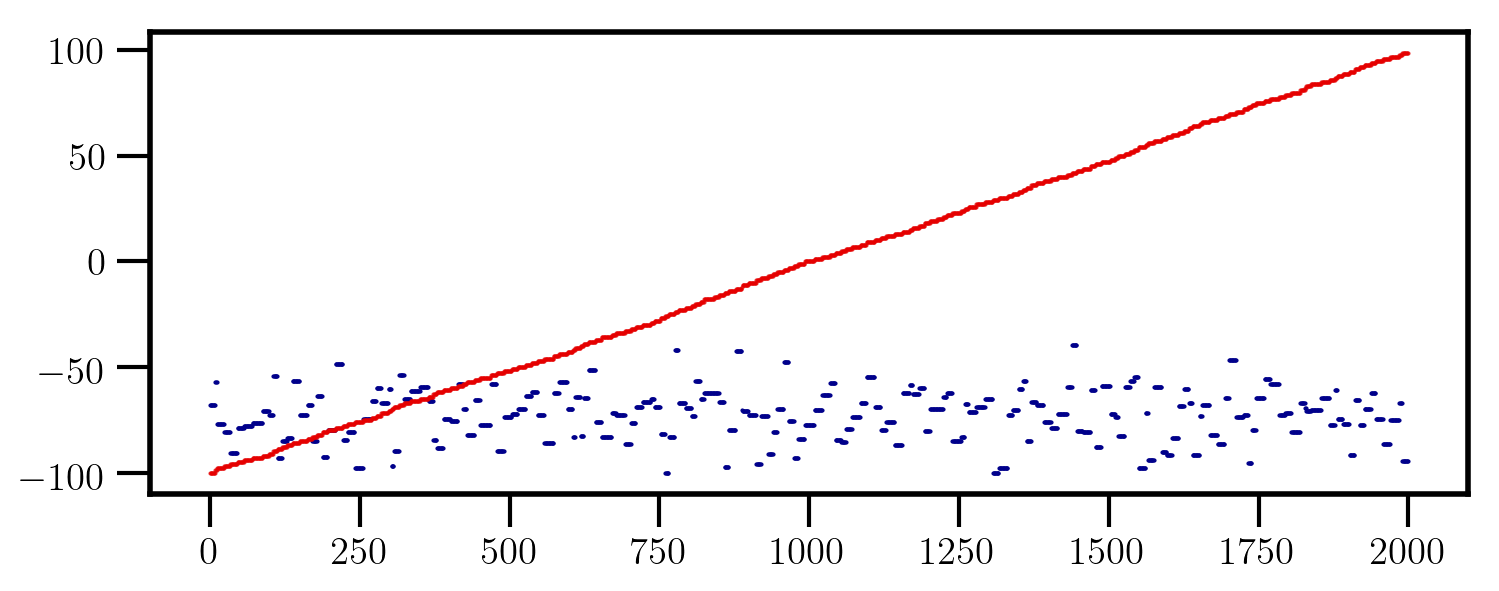

 epoch:   50 testing_std: 0.05797186121344566345 testing_cost: 0.05563390627503395081 testing_score: 111.26781463623046875000

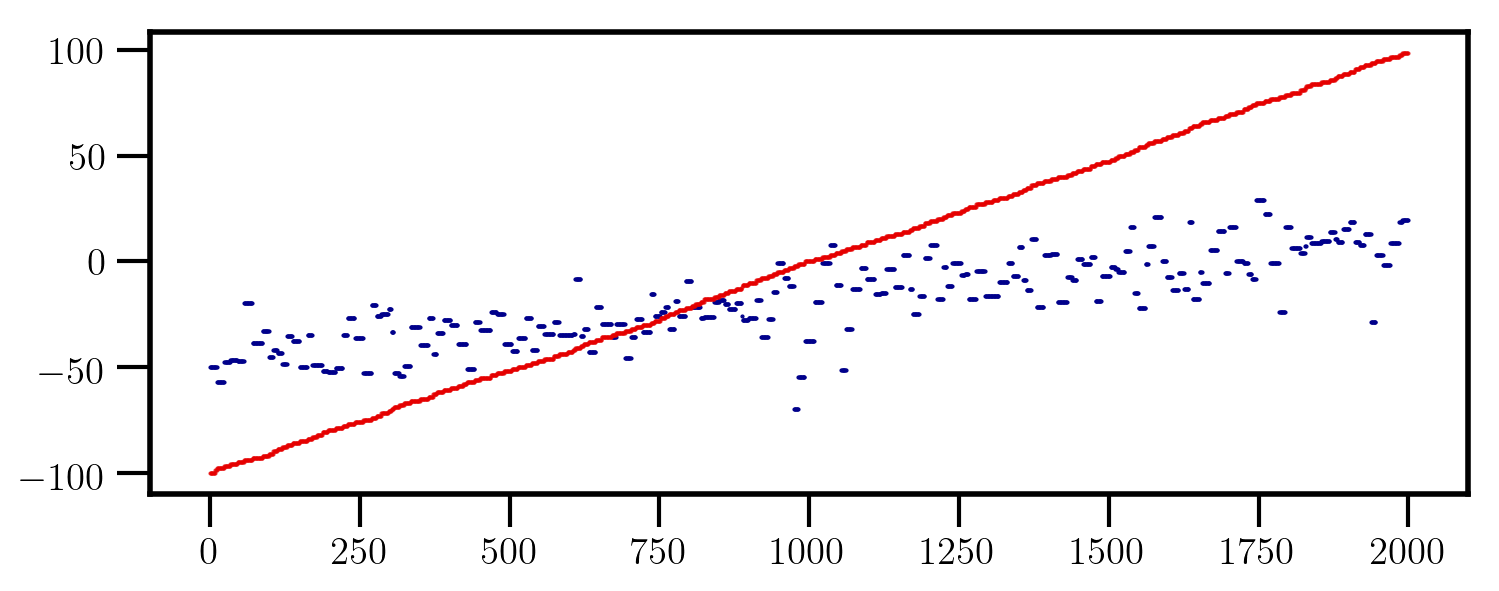

 epoch:  100 testing_std: 0.01479847636073827744 testing_cost: 0.00883273314684629440 testing_score: 17.665466308593750000000

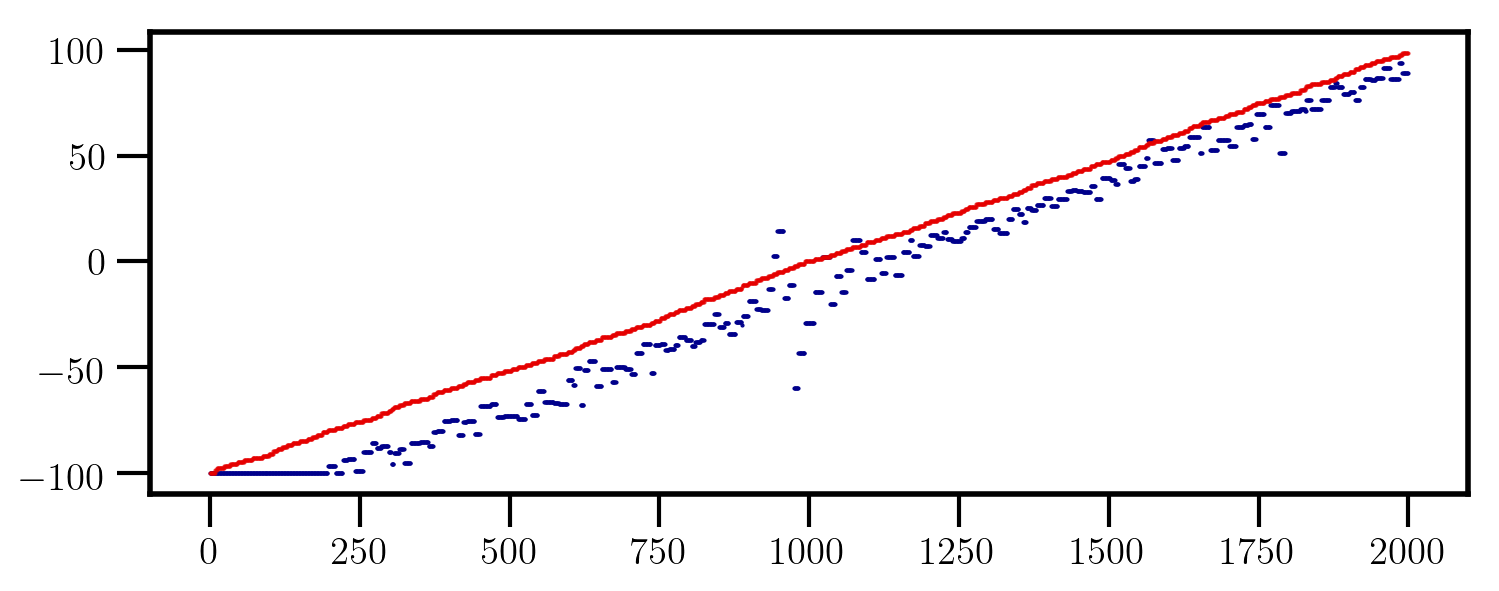

 epoch:  150 testing_std: 0.00835022237151861191 testing_cost: 0.00501347938552498817 testing_score: 10.02695846557617187500

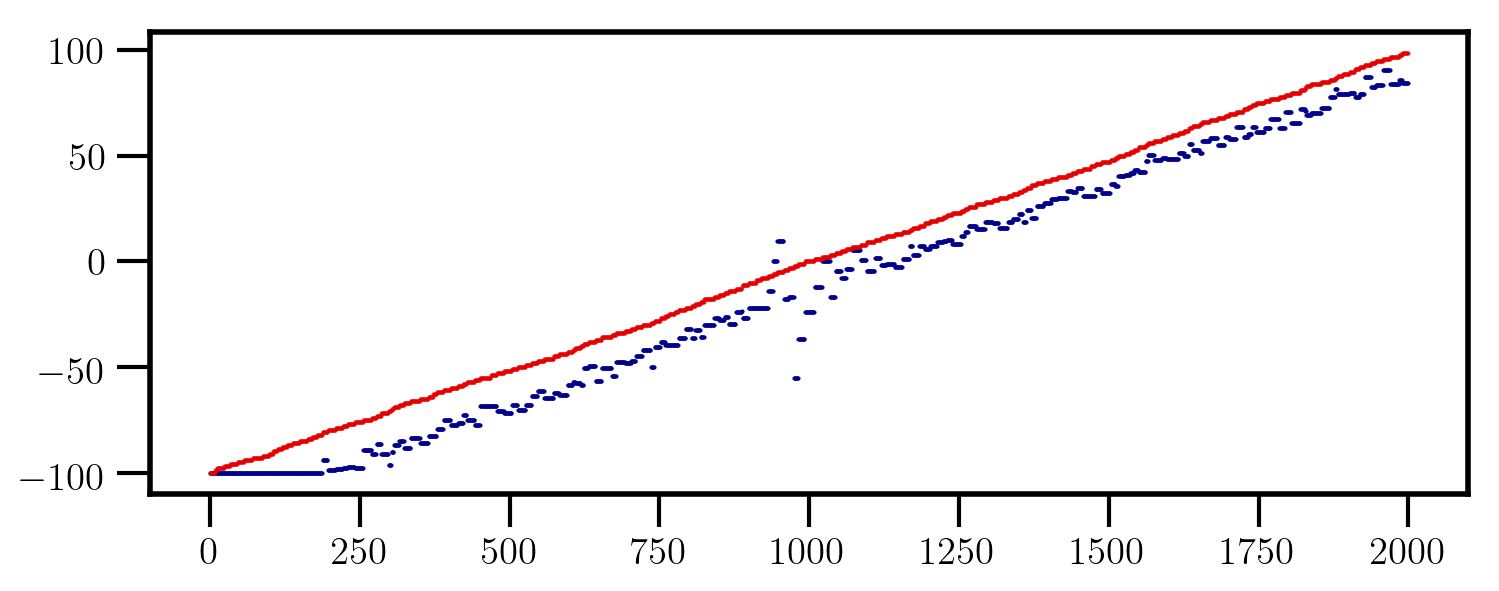

 epoch:  200 testing_std: 0.00579029507935047150 testing_cost: 0.00359790050424635410 testing_score: 7.195800781250000000000

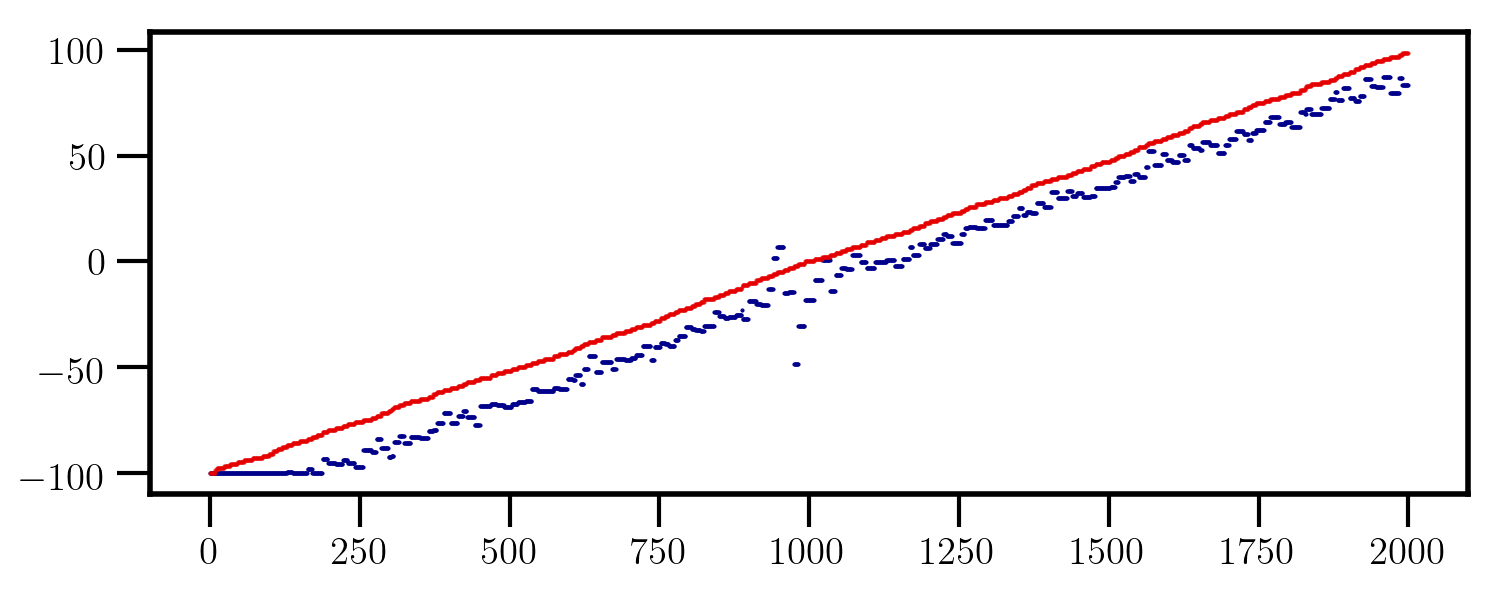

 epoch:  250 testing_std: 0.00521652074530720711 testing_cost: 0.00291925086639821529 testing_score: 5.83850193023681640625

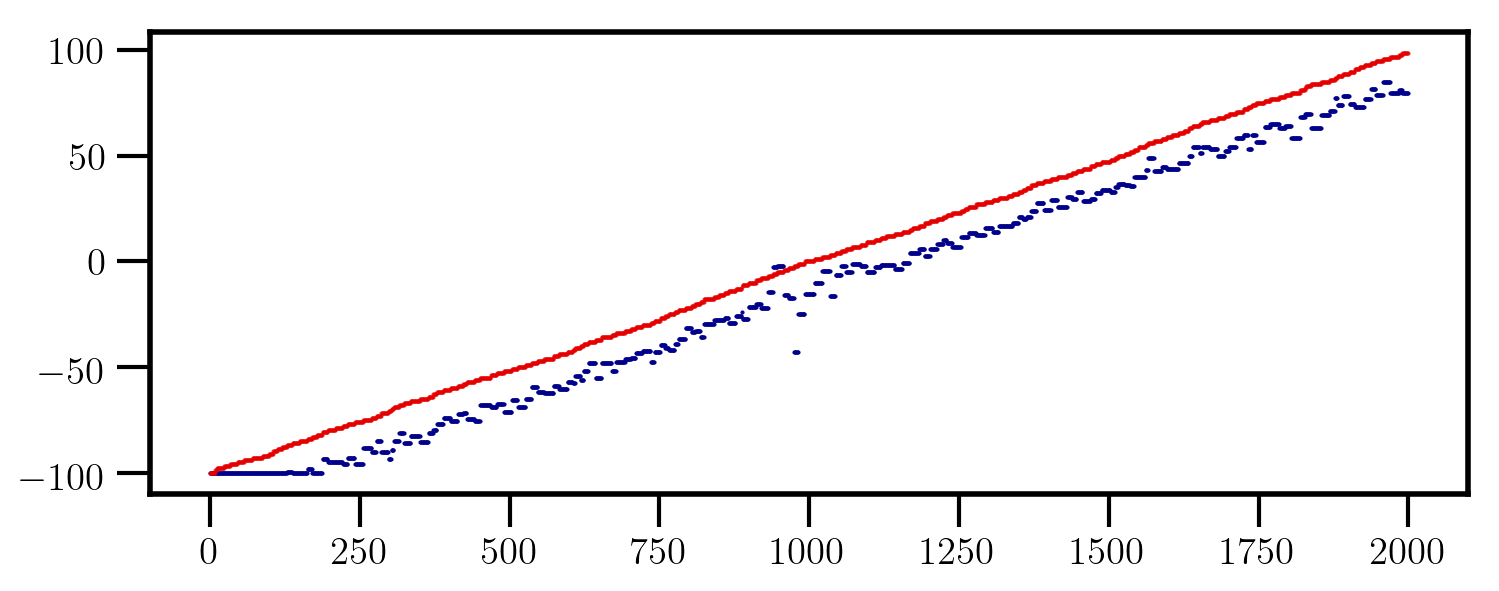

 epoch:  300 testing_std: 0.00398608110845088959 testing_cost: 0.00237480970099568367 testing_score: 4.74961948394775390625

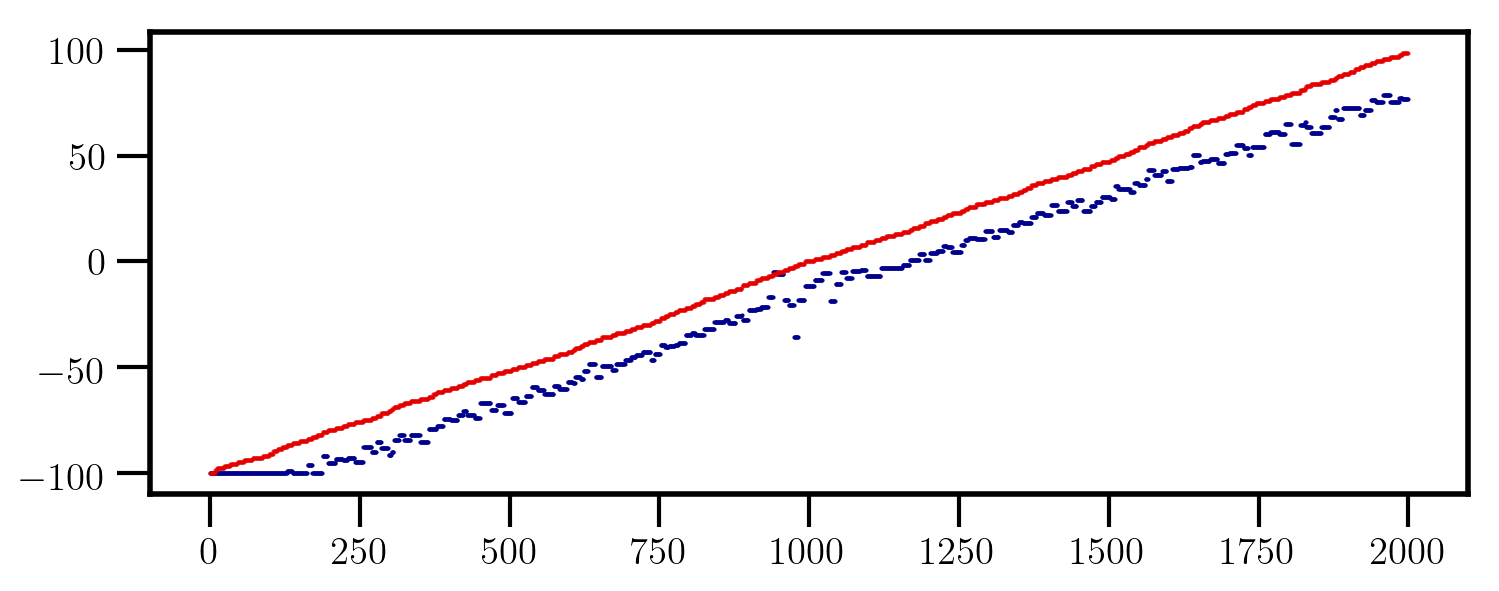

 epoch:  350 testing_std: 0.00341459107585251331 testing_cost: 0.00202849530614912510 testing_score: 4.05699062347412109375

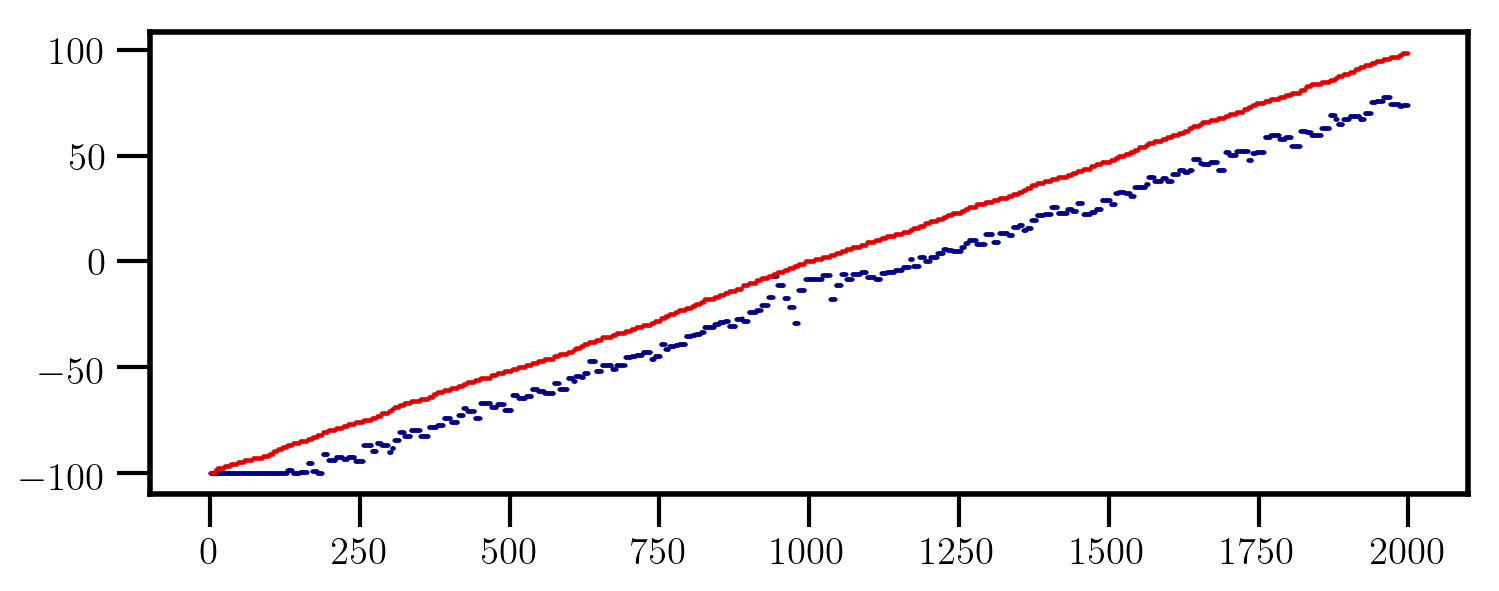

 epoch:  400 testing_std: 0.00305919582024216652 testing_cost: 0.00168923311866819859 testing_score: 3.37846612930297851562

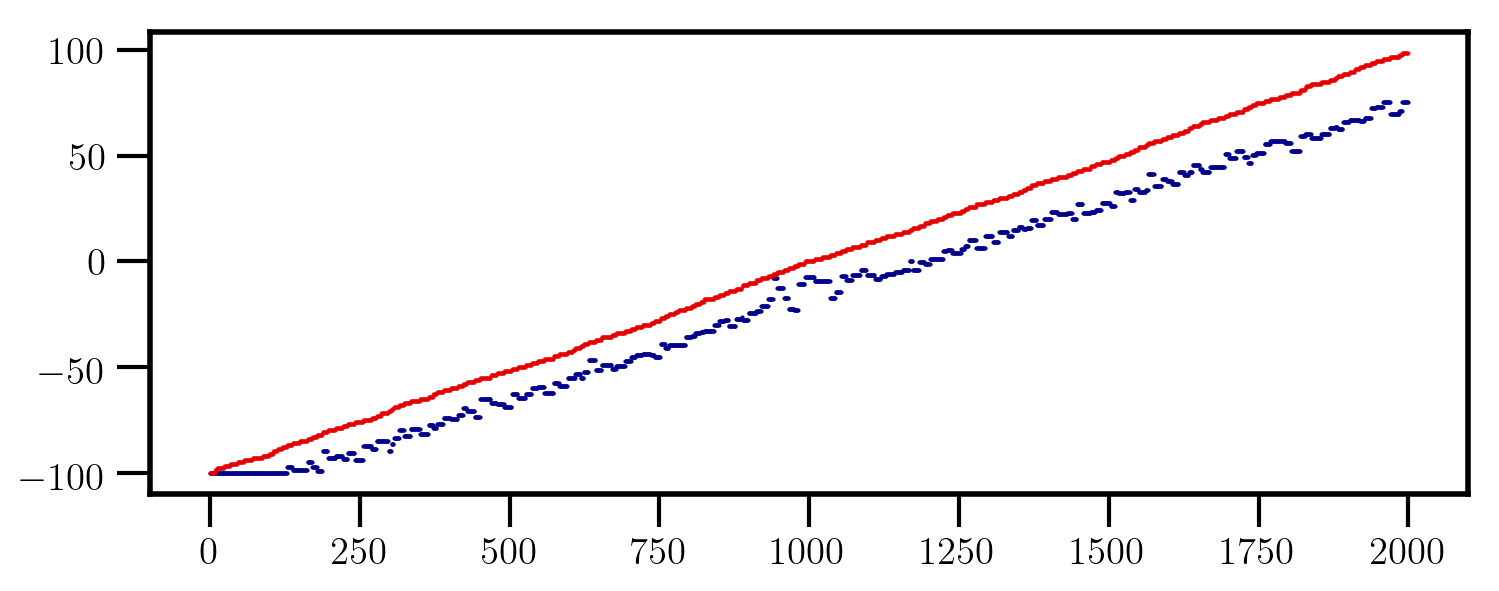

 epoch:  450 testing_std: 0.00283530796878039837 testing_cost: 0.00159603718202561140 testing_score: 3.19207429885864257812

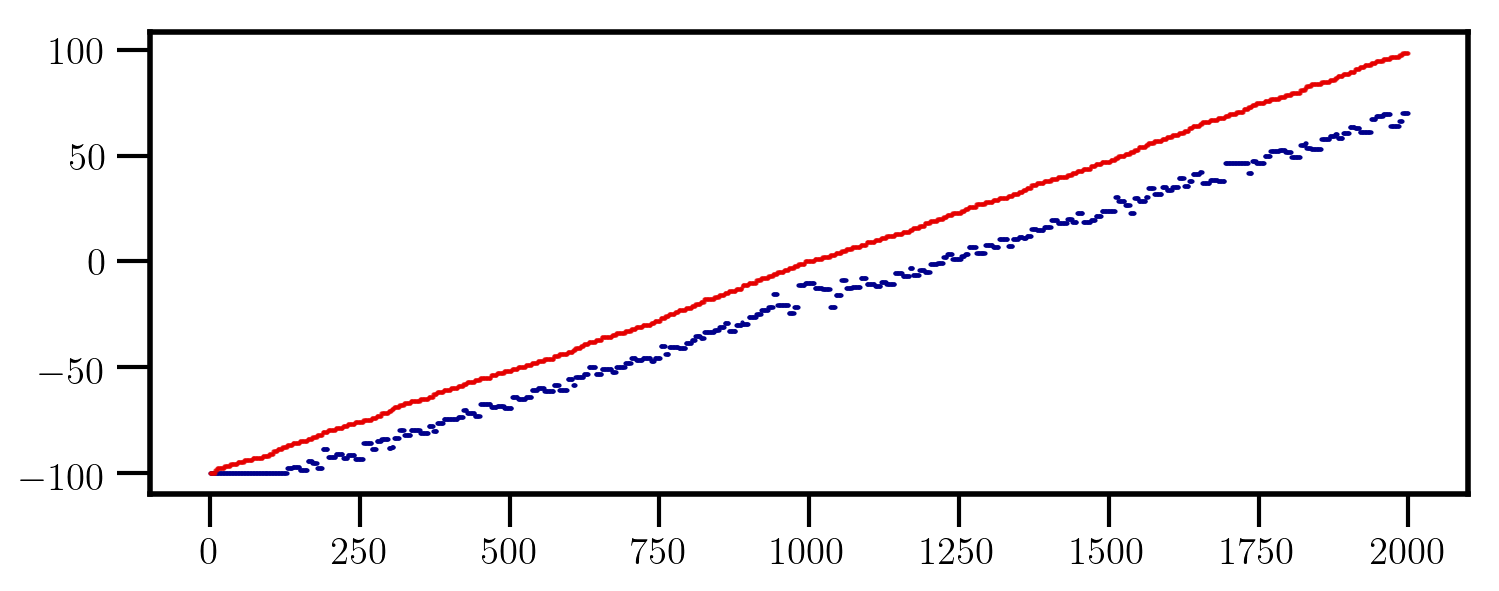

 epoch:  500 testing_std: 0.00212354166433215141 testing_cost: 0.00125594844575971365 testing_score: 2.51189684867858886719

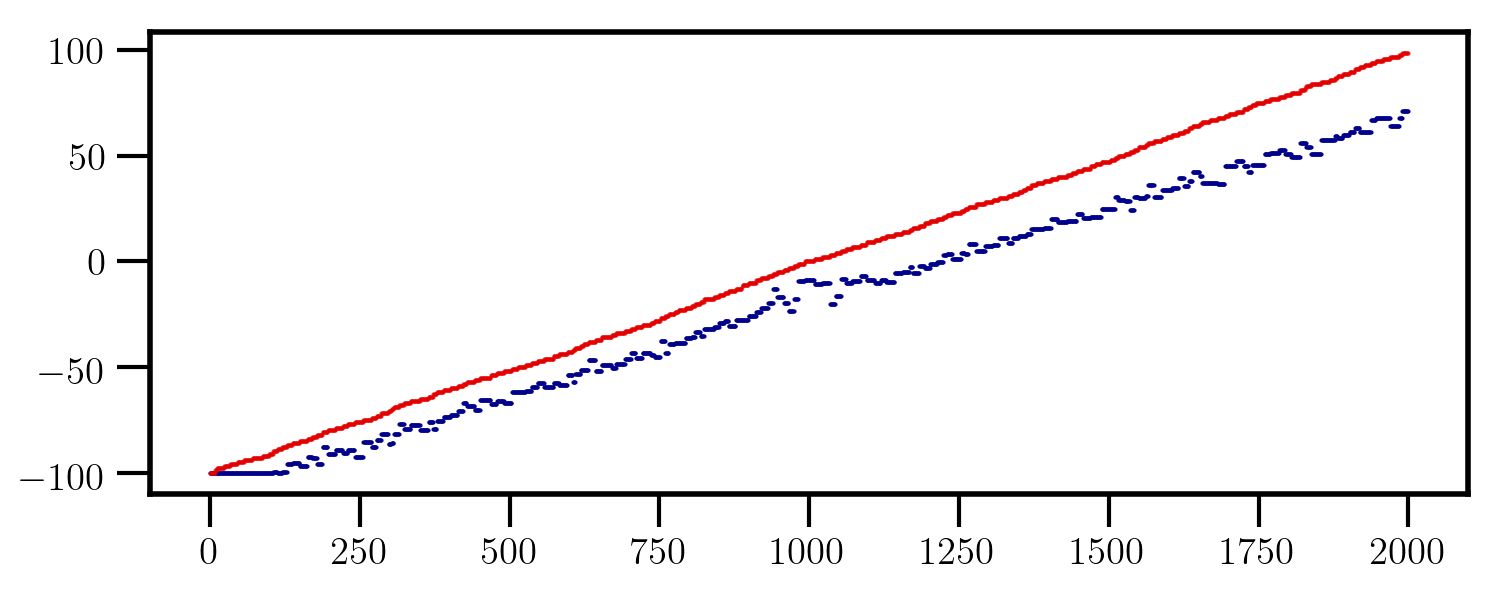

 epoch:  550 testing_std: 0.00201560743153095245 testing_cost: 0.00111946370452642441 testing_score: 2.23892736434936523438

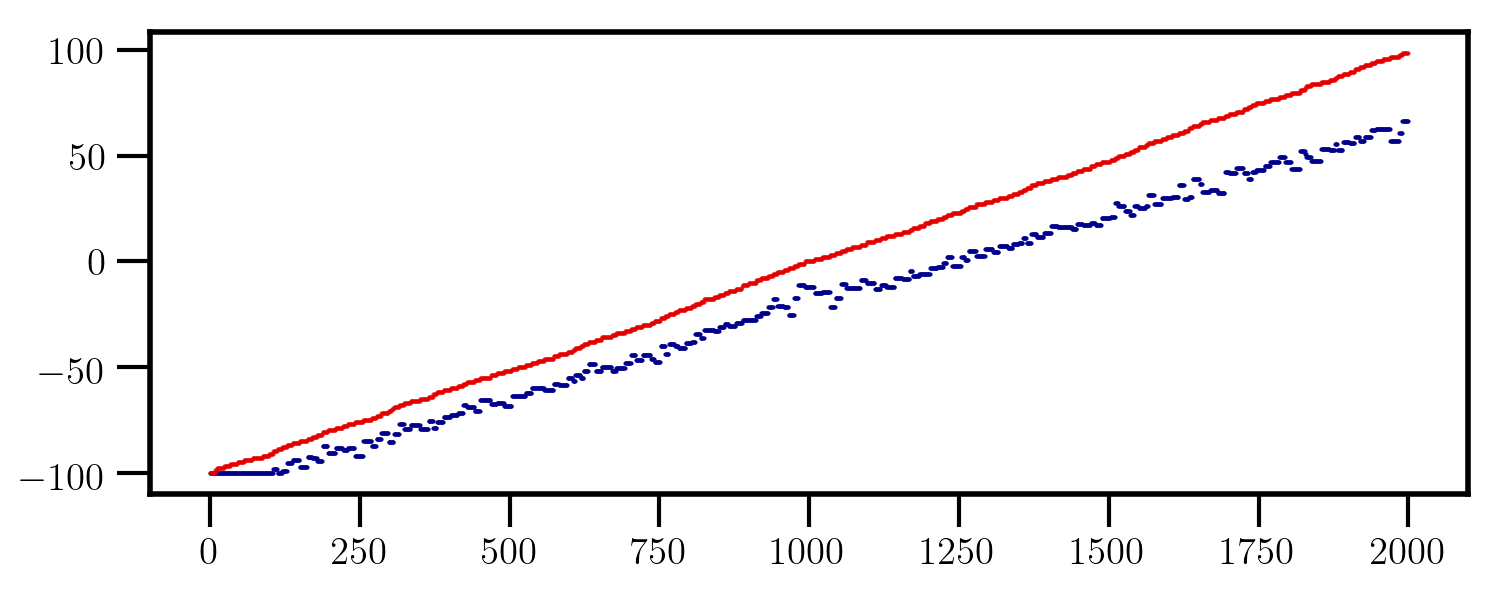

 epoch:  593 testing_std: 0.00167211785446852446 testing_cost: 0.00098397617693990469 testing_score: 1.96795237064361572266

KeyboardInterrupt: 

In [15]:

with tf.Session() as session:

    session.run(tf.global_variables_initializer())

    training_writer = tf.summary.FileWriter(log_direc + '/training', session.graph)
    testing_writer = tf.summary.FileWriter(log_direc + '/testing', session.graph)
    model_save_location = log_direc + '/model/' + 'trained_model.ckpt'

    
    for epoch  in range(training_epochs):

        # Feed in the training data and do one step NN training
        session.run(optimizer,feed_dict = {X: X_scaled_training,
                                           y_std: y_scaled_training,
                                           y_cost: y_scaled_training,
                                           y_score: y_scaled_training,
                                           keep_prob: 0.5})

        training_feed = {X: X_scaled_training,
                         y_std: y_scaled_training,
                         y_cost: y_scaled_training,
                         y_score: y_scaled_training,
                         keep_prob: 0.5}
        
        tr_std, tr_cost, tr_score, tr_summary = session.run([std, cost, score, summary], feed_dict = training_feed)

        testing_feed =  {X: X_scaled_testing,
                         y_std: y_scaled_testing,
                         y_cost: y_scaled_testing,
                         y_score: y_scaled_testing,
                         keep_prob: 0.5}
        
        tt_std, tt_cost, tt_score, tt_summary = session.run([std, cost, score, summary],feed_dict = testing_feed)
        
        sys.stdout.write('\r epoch: {:4.0f} testing_std: {:2.20f} testing_cost: {:2.20f} testing_score: {:2.20f}'.format(epoch, tt_std, tt_cost, tt_score))
        
        training_writer.add_summary(tr_summary, epoch)
        testing_writer.add_summary(tt_summary, epoch)
        testing_writer.flush()
        training_writer.flush()
        
        if epoch % 50 == 0:
                saver.save(session, model_save_location, epoch)
                prediction_scaled = session.run(prediction, feed_dict = {X: X_scaled_testing, keep_prob: 1})
                prediction_unscaled = y_scaler.inverse_transform(prediction_scaled)
                sorting_idx = np.argsort(y_testing.T[0])

                fig, ax = plt.subplots(figsize = (8.5, 3), dpi = 100)
                
                ax.plot(prediction_unscaled.T[0][sorting_idx],
                        linestyle = 'none', marker = '.', markersize = 1,
                        color = 'darkblue', label = 'Prediction')
                
                ax.plot(y_testing.T[0][sorting_idx],
                        linestyle = 'none', marker = '.', markersize = 1, alpha = 0.75, 
                        color = '#E50000', label = 'Actual')
                plt.show()
            
    saver.save(session, model_save_location, epoch)

In [ ]:
with tf.Session() as session:
    saver.restore(session,model_save_location + '-' + str(training_epochs - 1))
    
    prediction_scaled = session.run(prediction, feed_dict = {X: X_scaled_testing, keep_prob: 1})
    
    # the predictions but in the original units
    prediction_unscaled = y_scaler.inverse_transform(prediction_scaled)

In [ ]:
sorting_idx = np.argsort(y_testing.T[0])

fig, ax = plt.subplots(figsize = (8.5, 3), dpi = 100)

ax.set_title(r'NN predictions vs actual, final cost $\approx$ 5/1000')
ax.plot(prediction_unscaled.T[0][sorting_idx],
        linestyle = 'none', marker = '.', markersize = 1,
        color = 'darkblue', label = 'Prediction')

ax.plot(y_testing.T[0][sorting_idx],
        linestyle = 'none', marker = '.', markersize = 1, alpha = 0.75, 
        color = '#E50000', label = 'Actual')

ax.set_ylabel(r'$\tau$ [ ns ]')
ax.set_xlabel(r'$\texttt{Y\_testing}$ sample number')
ax.legend( loc = 'best')
plt.show()

In [ ]:
NN_SCORE = sum((y_scaled_testing.T[0] - prediction_scaled.T[0])**2)
NN_SCORE

In [ ]:
np.std(abs(y_testing.T[0] - prediction_unscaled.T[0]))